In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Densité spectrale du bruit d'une machine à laver

In [2]:
from scipy.io.wavfile import read
samplerate, amplitude = read('data/machine_a_laver.wav')

In [5]:
print(samplerate)
delta_t = 1/samplerate
N = len(amplitude)
print(N)
T = N*delta_t
print(T)

44100
414380
9.396371882086168


Text(0,0.5,'Amplitude')

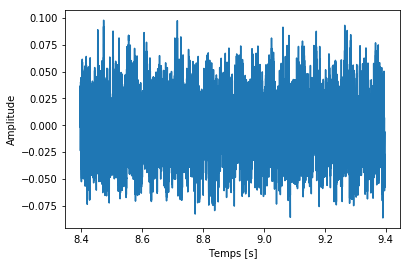

In [9]:
t = np.arange(N)*delta_t

plt.plot(t[-44100:], amplitude[-44100:])
plt.xlabel('Temps [s]')
plt.ylabel('Amplitude')

In [13]:
from scipy.signal import periodogram
freq, psd = periodogram(amplitude, samplerate)

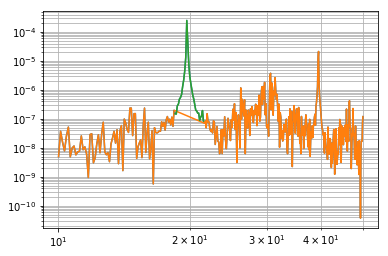

In [24]:
mask = (freq>=10) & (freq<50)
plt.loglog(freq[mask], psd[mask])
plt.grid(which='both')

mask_pic = np.abs(freq-20)<1.5

plt.loglog(freq[mask& ~mask_pic], psd[mask& ~mask_pic])
plt.loglog(freq[mask_pic], psd[mask_pic])


In [26]:
print(np.var(amplitude))

Delta_f = 1/T
print(np.sum(psd)*Delta_f)

0.0006080771214276875
0.0006080771214276876


In [31]:
print('Signal', np.sum(psd[mask_pic]*Delta_f))
print('Bruit', np.sum(psd[~mask_pic])*Delta_f)

Signal 3.5692487869074834e-05
Bruit 0.0005723846335586126


In [28]:
Delta_f = freq[1] - freq[0]
print(Delta_f, 1/T)

0.10642405521502003 0.10642405521502003


In [29]:
np.std(amplitude)

0.024659219805737723

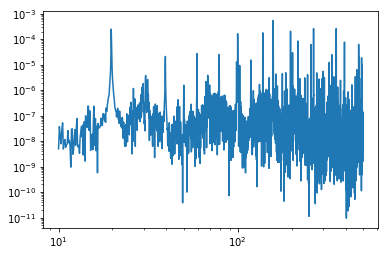

In [32]:
mask = (freq>=10) & (freq<500)
plt.loglog(freq[mask], psd[mask])


## Filtre en Python

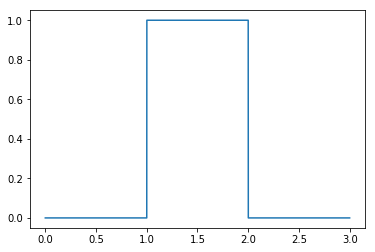

In [45]:
samplerate = 44100
delta_t = 1/samplerate
signal = np.zeros(samplerate*3)
signal[samplerate:samplerate*2] = 1
t = np.arange(len(signal))*delta_t
plt.plot(t, signal)

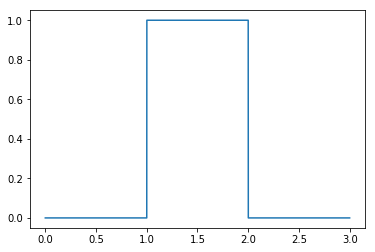

In [46]:
import numpy as np
signal_tilde = np.fft.rfft(signal)
signal_2 = np.fft.irfft(signal_tilde)
plt.plot(t, signal_2)

In [47]:
np.fft.rfftfreq(len(signal), d=delta_t)
# 1/T => samplerate/2

array([0.00000000e+00, 3.33333333e-01, 6.66666667e-01, ...,
       2.20493333e+04, 2.20496667e+04, 2.20500000e+04])

In [57]:
def pass_bas(signal, f_c, samplerate=44100):
    signal_tilde = np.fft.rfft(signal)
    freqs = np.fft.rfftfreq(len(signal), 1/samplerate)
    H = 1/(1+1J*(freqs/f_c))
    signal_2 = np.fft.irfft(H*signal_tilde)
    return signal_2

In [59]:
def pass_haut(signal, f_c, samplerate=44100):
    signal_tilde = np.fft.rfft(signal)
    freqs = np.fft.rfftfreq(len(signal), 1/samplerate)
    H = 1J*(freqs/f_c)/(1+1J*(freqs/f_c))
    signal_2 = np.fft.irfft(H*signal_tilde)
    return signal_2

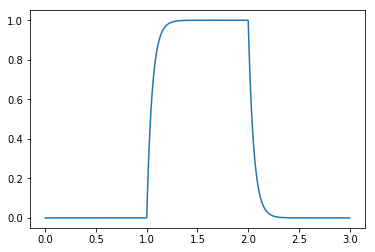

In [60]:
signal_filtre = pass_bas(signal, f_c=3)
plt.plot(t, signal_filtre)

In [62]:
from scipy.io.wavfile import read
samplerate, amplitude = read('data/machine_a_laver.wav')

amplitude_filtree = pass_bas(amplitude, 30, samplerate=samplerate)

Text(0,0.5,'Amplitude')

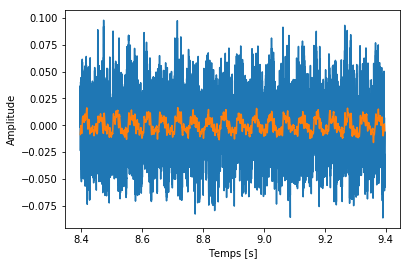

In [64]:
t = np.arange(N)*delta_t

plt.plot(t[-44100:], amplitude[-44100:])
plt.plot(t[-44100:], amplitude_filtree[-44100:])
plt.xlabel('Temps [s]')
plt.ylabel('Amplitude')

## Onde gravitationnelle

In [ ]:
from readligo import loaddata
filename_H1 = 'data/H-H1_LOSC_4_V1-1126259446-32.hdf5'
strain_H1, time_H1, chan_dict_H1 = loaddata(filename_H1, 'H1')

In [ ]:
f, psd = welch(strain_H1, samplerate, nperseg=samplerate)

In [ ]:
from scipy.interpolate import interp1d    

def whiten(strain, dt):
    freqs_welch, psd_welch = welch(strain, fs=1/dt, nperseg=int(1/dt))
    interp_psd = interp1d(freqs_welch, psd_welch)

    strain_tilde = np.fft.rfft(strain)
    N = len(strain)
    freqs = np.fft.rfftfreq(N, dt)

    gain = 1 / np.sqrt(interp_psd(freqs))
    gain = gain/gain.max()
    white_strain_tilde = strain_tilde * gain
    white_strain = np.fft.irfft(white_strain_tilde)
    return white_strain